# Imports

In [38]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml
sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

# Some Initialization Parameters for AWS

In [39]:
# code to create a new bucket or use an existing bucket with allowed permissions
useExistingBucket = True
#if true , use exiting models else create a new model, make sure name is unique and add it to our 
#existing bucket only create a new folder
FreireBucket = "freirebros-deepracer" #bucketname , this is global bucket (S3 Bucket)

#the pretrained folder is incase yo have an old model already trained
#if you have non then just call it ""
#DO NOT PUT A  SLASH AT THE END IT MESSES EVERYTHING UP
pretrainedModelPrefix = "AndreiModels/Model-Andrei-Trial-3-SM" #this is the prefix name (a folder within sagemaker S3)
#new model directory
NewModelPrefix = "AndreiModels/Model-Andrei-Trial-4-usingT3-SM"

# Select the instance type
instance_type = "ml.c4.2xlarge"
#instance_type = "ml.p2.xlarge"
#instance_type = "ml.c5.4xlarge"


if not FreireBucket: 
    raise SystemExit("Please Enter a Bucket Name")

# Starting SageMaker session
sage_session = sagemaker.session.Session(default_bucket = FreireBucket)

# Create unique job name.
job_name_prefix = 'deepracer-notebook'

# Duration of job in seconds (1 hours)
job_duration_in_seconds = 3600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia),"
                    "US West (Oregon) and EU (Ireland). Please switch to one of these regions.")

# AWS Resources setup 
## taken from AWS examples - DO NOT CHANGE

In [40]:
#Fetch S3 Bucket Resource
if not NewModelPrefix:
    raise systemExit("pleaser Enter a Prefix Name (Folder where the model is stored)")
# S3 bucket
if not useExistingBucket:
    s3_bucket = sage_session.default_bucket()
else:
    s3_bucket = FreireBucket
# SDK appends the job name and output folder
s3_output_path = 's3://{}/'.format(s3_bucket)

#Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = NewModelPrefix

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']

print("Using s3 bucket {}".format(s3_bucket))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket, s3_prefix))

#set permisions Resource
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

#In case reader want to implement themselves
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

#build AWS Docker Resource

%time
from copy_to_sagemaker_container import get_sagemaker_docker, copy_to_sagemaker_container, get_custom_image_name
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)
    
    

#configure VPC Resource
ec2 = boto3.client('ec2')

#
# Check if the user has Deepracer-VPC and use that if its present. This will have all permission.
# This VPC will be created when you have used the Deepracer console and created one model atleast
# If this is not present. Use the default VPC connnection
#
deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups']\
                             if group['GroupName'].startswith("aws-deepracer-")]

# deepracer_security_groups = False
if(deepracer_security_groups):
    print("Using the DeepRacer VPC stacks. This will be created if you run one training job from console.")
    deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] \
                     if "Tags" in vpc for val in vpc['Tags'] \
                     if val['Value'] == 'deepracer-vpc'][0]
    deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                         if subnet["VpcId"] == deepracer_vpc]
else:
    print("Using the default VPC stacks")
    deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

    deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                                 if 'VpcId' in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc]

    deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                         if subnet["VpcId"] == deepracer_vpc and subnet['DefaultForAz']==True]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

#create Route Table resourses
#TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True

def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                        if route_table['VpcId'] == deepracer_vpc]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)
    
    if not route_tables:
        raise Exception(("No route tables were found. Please follow the VPC S3 endpoint creation "
                         "guide by clicking the above link."))
    try:
        ec2.create_vpc_endpoint(DryRun=False,
                                VpcEndpointType="Gateway",
                                VpcId=deepracer_vpc,
                                ServiceName="com.amazonaws.{}.s3".format(aws_region),
                                RouteTableIds=route_tables)
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()
    



Using s3 bucket freirebros-deepracer
Model checkpoints and other metadata will be stored at: 
s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM
Using Sagemaker IAM role arn: 
arn:aws:iam::204747776045:role/service-role/AmazonSageMaker-ExecutionRole-20210210T204480


1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonKinesisVideoStreamsFullAccess` policy


1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Sagemaker docker id : 5905673d9489
docker run -d -t 5905673d9489
docker exec -d 956f4a948be533bfe4a0b8679fec3bfab8d4218196863ea9e3f4c44f93f9fb40 rm -rf /opt/amazon/markov
docker cp ./src/markov 956f4a948be533bfe4a0b8679fec3bfab8d4218196863ea9e3f4c44f93f9fb40:/opt/amazon/markov
============ Copied Markov scripts to sagemaker docker ============ 
 
docker ps -l|sed -n 2,2p
docker commit 956f4a948be5 sagemaker-docker-cpu
============ Commited all the changes to docker ============ 
 
Using the default VPC stacks
Using VPC: vpc-6cebf416
Using security group: ['sg-26446204']
Using subnets: ['subnet-f638fb90', 'subnet-00ef2621', 'subnet-57bb7408', 'subnet-62283e5c', 'subnet-2293016f', 'subnet-f4d551fa']
Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-d36ff5ad']
S3 endpoint already exists.

# Set Up Training Environment


In [41]:
#copy any custom files such as 
#custom reward function
#meta_data
#presets -> action space
#attention layer

s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/andrei_reward_optimized_turns.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/front_deep_two_speed_5steering.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py



s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM
upload: src/artifacts/rewards/andrei_reward_optimized_turns.py to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/customer_reward_function.py
upload: src/artifacts/actions/front_deep_two_speed_5steering.json to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/model/model_metadata.json


In [42]:
#set Metric we want to collect
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

# TRAIN
Configure hyper parameters
exploration type che k : https://intellabs.github.io/coach/components/exploration_policies/index.html
Categorical
i will choose EGreedy

In [43]:
estimator = RLEstimator(entry_point="training_worker.py",
                        source_dir='src',
                        image_uri=custom_image_name,
                        dependencies=["common/"],
                        role=sagemaker_role,
                        instance_type=instance_type,
                        instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        max_run=job_duration_in_seconds,
                        hyperparameters={
                            "s3_bucket": s3_bucket,
                            "s3_prefix": s3_prefix,
                            "aws_region": aws_region,
                            "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
                            "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
                            "batch_size": "64",
                            "num_epochs": "10",
                            "stack_size": "1",
                            "lr": "0.0003",
                            "exploration_type": "Categorical",
                            "e_greedy_value": "1",
                            "epsilon_steps": "10000",
                            "beta_entropy": "0.01",
                            "discount_factor": "0.95",
                            "loss_type": "Huber",
                            "num_episodes_between_training": "20",
                            "max_sample_count": "0",
                            "sampling_frequency": "1"
                            ,"pretrained_s3_bucket": FreireBucket
                            ,"pretrained_s3_prefix": pretrainedModelPrefix
                        },
                        subnets=deepracer_subnets,
                        security_group_ids=deepracer_security_groups,
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: deepracer-notebook-2021-03-28-02-06-12-181


In [44]:
#Get Info
training_job_arn = estimator.latest_training_job.describe()['TrainingJobArn']

# AWS Simulation and Robot Resources 
##  taken from AWS examples - DO NOT CHANGE

In [45]:
    
s3_yaml_name="training_params.yaml"
world_name = "reInvent2019_track"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['SAGEMAKER_SHARED_S3_BUCKET']  = s3_bucket
yaml_config['SAGEMAKER_SHARED_S3_PREFIX']  = s3_prefix
yaml_config['TRAINING_JOB_ARN']            = training_job_arn
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/training_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/training".format(s3_prefix)
yaml_config['AWS_REGION']                  = aws_region
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['KINESIS_VIDEO_STREAM_NAME']   = kvs_stream_name
yaml_config['REWARD_FILE_S3_KEY']          = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config['MODEL_METADATA_FILE_S3_KEY']  = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config['NUM_WORKERS']                 = num_simulation_workers
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml


JOB_TYPE                                : TRAINING
WORLD_NAME                              : reInvent2019_track
SAGEMAKER_SHARED_S3_BUCKET              : freirebros-deepracer
SAGEMAKER_SHARED_S3_PREFIX              : AndreiModels/Model-Andrei-Trial-4-usingT3-SM
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:204747776045:training-job/deepracer-notebook-2021-03-28-02-06-12-181
METRICS_S3_BUCKET                       : freirebros-deepracer
METRICS_S3_OBJECT_KEY                   : AndreiModels/Model-Andrei-Trial-4-usingT3-SM/training_metrics.json
SIMTRACE_S3_BUCKET                      : freirebros-deepracer
SIMTRACE_S3_PREFIX                      : AndreiModels/Model-Andrei-Trial-4-usingT3-SM/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CHANGE_START_POSITION                   : true
ALTERNAT

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./training_params.yaml to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/training_params.yaml


In [46]:
#kinesis video stream
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))

# robomaker
robomaker = boto3.client("robomaker")

#simulation
#we shoould consider usin gazebo version 9
robomaker_s3_key = 'robomaker/simulation_ws.tar.gz'
robomaker_source = {'s3Bucket': s3_bucket,
                    's3Key': robomaker_s3_key,
                    'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE',
                  'version': '1.x'}

if not os.path.exists('./build/output.tar.gz'):
    print("Using the latest simapp from public s3 bucket")
    # Download Robomaker simApp for the deepracer public s3 bucket
    simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
    !aws s3 cp {simulation_application_bundle_location} ./

    # Remove if the Robomaker sim-app is present in s3 bucket
    !aws s3 rm s3://{s3_bucket}/{robomaker_s3_key}

    # Uploading the Robomaker SimApp to your S3 bucket
    !aws s3 cp ./deepracer-simapp.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

    # Cleanup the locally downloaded version of SimApp
    !rm deepracer-simapp.tar.gz
else:
    print("Using the simapp from build directory")
    !aws s3 cp ./build/output.tar.gz s3://{s3_bucket}/{robomaker_s3_key}
        
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(name=app_name,
                                                       sources=[robomaker_source],
                                                       simulationSoftwareSuite=simulation_software_suite,
                                                       robotSoftwareSuite=robot_software_suite,
                                                       renderingEngine=rendering_engine)
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

        

vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    client_request_token = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    envriron_vars = {
        "S3_YAML_NAME": s3_yaml_name,
        "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
        "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
        "WORLD_NAME": world_name,
        "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
        "APP_REGION": aws_region,
        "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
        "ROLLOUT_IDX": str(job_no)
    }

    simulation_application = {"application":simulation_app_arn,
                              "launchConfig": {"packageName": "deepracer_simulation_environment",
                                               "launchFile": "distributed_training.launch",
                                               "environmentVariables": envriron_vars}
                             }
    response =  robomaker.create_simulation_job(iamRole=sagemaker_role,
                                            clientRequestToken=client_request_token,
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Fail",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig
                                            )
    responses.append(response)
    time.sleep(5)
    

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:204747776045:stream/dr-kvs-deepracer-notebook-2021-03-28-02-06-12-181/1616897183339"
}
Created kinesis video stream dr-kvs-deepracer-notebook-2021-03-28-02-06-12-181
Using the latest simapp from public s3 bucket
download: s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz to ./deepracer-simapp.tar.gz
delete: s3://freirebros-deepracer/robomaker/simulation_ws.tar.gz
upload: ./deepracer-simapp.tar.gz to s3://freirebros-deepracer/robomaker/simulation_ws.tar.gz
deepracer-notebook-application210328-020706
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:204747776045:simulation-application/deepracer-notebook-application210328-020706/1616897226587
Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-bxyq1d24yhmz


In [47]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-bxyq1d24yhmz)  

You can click on Gazebo after you open the above link to start the simulator.

# Lauch Simulation with parameters

In [48]:
#tracks you can use, there may be more now need to recheck....
# Albert.world                      Mexico_track.world                reinvent_wood.world
# AmericasGeneratedInclStart.world  Monaco_building.world             Singapore_building.world
# Aragon.world                      Monaco.world                      Singapore_f1.world
# Austin.world                      New_York_Track.world              Singapore.world
# AWS_track.world                   Oval_track.world                  Spain_track_f1.world
# Belille.world                     reInvent2019_track.world          Spain_track.world
# Bowtie_track.world                reInvent2019_wide_mirrored.world  Straight_track.world
# Canada_Training.world             reInvent2019_wide.world           Tokyo_Training_track.world
# China_track.world                 reinvent_base_jeremiah.world      Vegas_track.world
# FS_June2020.world                 reinvent_base.world               Virtual_May19_Train_track.world
# July_2020.world                   reinvent_carpet.world
# LGSWide.world                     reinvent_concrete.world

# PLOT RESULTS

In [49]:
#create ploting temp directories
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2021-03-28-02-06-12-181


Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/training_metrics.json...


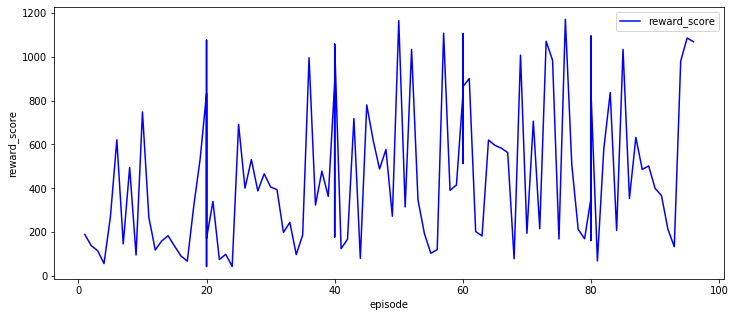

In [52]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
viewModelMetrics = NewModelPrefix
training_metrics_path = "{}/{}".format(viewModelMetrics, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
x_axis = 'episode'
y_axis = 'reward_score'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

# Evaluation

In [53]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = s3_bucket
yaml_config['MODEL_S3_PREFIX']             = s3_prefix
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

display(Markdown(generate_robomaker_links(job_arns, aws_region)))

JOB_TYPE                                : EVALUATION
WORLD_NAME                              : reInvent2019_track
MODEL_S3_BUCKET                         : freirebros-deepracer
MODEL_S3_PREFIX                         : AndreiModels/Model-Andrei-Trial-4-usingT3-SM
AWS_REGION                              : us-east-1
METRICS_S3_BUCKET                       : freirebros-deepracer
METRICS_S3_OBJECT_KEY                   : AndreiModels/Model-Andrei-Trial-4-usingT3-SM/evaluation_metrics.json
SIMTRACE_S3_BUCKET                      : freirebros-deepracer
SIMTRACE_S3_PREFIX                      : AndreiModels/Model-Andrei-Trial-4-usingT3-SM/iteration-data/evaluation
NUMBER_OF_TRIALS                        : 5
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CAR_COLOR                               : Grey
NUMBER_OF_RESETS                        : 10000
PENALTY_SECONDS                         : 2.0
IS_CONTINUOUS                           : false
OFF_TRACK_PENALTY                       : 0.0


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./evaluation_params.yaml to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/evaluation_params.yaml
Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-ygctvwty6wrx


> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-ygctvwty6wrx)  

You can click on Gazebo after you open the above link to start the simulator.

## Plot Evaluation

In [54]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time']]

display(df)

Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-4-usingT3-SM/evaluation_metrics.json.....................................


,trial,completion_percentage,elapsed_time
0,1,100,25.42


# Head To Head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"
if not s3_prefix_2:
    raise Exception("Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between")

print("Using s3 bucket {}".format(s3_bucket_2))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket_2, s3_prefix_2))


s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MODEL_S3_PREFIX']             = [s3_prefix,
                                              s3_prefix_2]
yaml_config['MODEL_METADATA_FILE_S3_KEY']  =["{}/model/model_metadata.json".format(s3_prefix),
                                             "{}/model/model_metadata.json".format(s3_prefix_2)]
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = [s3_bucket,
                                              s3_bucket_2]
yaml_config['METRICS_S3_OBJECT_KEY']       = ["{}/evaluation_metrics.json".format(s3_prefix),
                                              "{}/evaluation_metrics.json".format(s3_prefix_2)]
yaml_config['SIMTRACE_S3_BUCKET']          = [s3_bucket,
                                              s3_bucket_2]
yaml_config['SIMTRACE_S3_PREFIX']          = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MP4_S3_OBJECT_PREFIX']        = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)
    
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

## Plot H2H Evaluation

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_1 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_1['elapsed_time'] = df_1['elapsed_time_in_milliseconds']/1000
df_1 = df_1[['trial', 'completion_percentage', 'elapsed_time']]

display(df_1)

evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_2 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_2['elapsed_time'] = df_2['elapsed_time_in_milliseconds']/1000
df_2 = df_2[['trial', 'completion_percentage', 'elapsed_time']]

display(df_2)

# CLEAN UP TRAININING

In [16]:
# Cancelling robomaker job
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

# Stopping sagemaker training job
sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

ClientError: An error occurred (ValidationException) when calling the StopTrainingJob operation: The request was rejected because the training job is in status Failed.

# Remove Docker

In [17]:
#if you ever run this Docker/Cell please do not forget to clean and remove docker
!docker rm -f $(docker ps -a -q);
!docker rmi -f $(docker images -q);

"docker rm" requires at least 1 argument.
See 'docker rm --help'.

Usage:  docker rm [OPTIONS] CONTAINER [CONTAINER...]

Remove one or more containers
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu:latest
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu@sha256:311e33cc5597dec45898b8425ceaa7a4bfea37ee14d1e5ddf13a3177f3f822d4
Untagged: sagemaker-docker-cpu:latest
Deleted: sha256:a904ab95c7a35b830a5267f566bd28bede8d307a7a27f60c24e40cbddfb0bc17
Deleted: sha256:b4b253ed4565b8d70247ccde7115cf6e300111b22c2b62fa2ad3af3261a245a5
Deleted: sha256:1d004049bb6046439ca5d661098fee69f921ddc0dc7c57b2eddd793b4b248757
Deleted: sha256:d39a8e35ba8a9fb716015c5299080cd237f4674d28b9854accbf1336270c8779
Deleted: sha256:77464388d93440bdf5d1443c6847c8cc6b3020840fc5716ac7db67a1189eb27a
Deleted: sha256:3d283a45ac5bb1a882adb2285b810db1a7b94fc567cc53ee511e796bf45dbcc3
Deleted: sha256:ac9d0431976b42bf64834b2f491e4c059471a928b24cd47e79c73d48a88a0b08
Deleted: sha2

# Clean Up simulation 

In [18]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '16ff5a40-f9b5-4f98-a30f-07732d059d02',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 27 Mar 2021 23:27:40 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '16ff5a40-f9b5-4f98-a30f-07732d059d02',
   'x-amz-apigw-id': 'c3rY-HVtIAMFgiw=',
   'x-amzn-trace-id': 'Root=1-605fbf6c-73e272b45b77ca7d225dcc3b'},
  'RetryAttempts': 0}}

# Clean S3 Buckets

In [19]:
# Uncomment if you only want to clean the s3 bucket
sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
!aws s3 rm --recursive {sagemaker_s3_folder}

robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
!aws s3 rm --recursive {robomaker_s3_folder}

robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
!aws s3 rm --recursive {robomaker_sim_app}

model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
!aws s3 rm --recursive {model_output}

delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/customer_reward_function.py
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/ip/hyperparameters.json
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/model/model_metadata.json
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/ip/ip.json
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/training_params.yaml
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Trial-3-SM/ip/done
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-37-12-325/output/model.tar.gz
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-37-12-325/profiler-output/system/incremental/2021032722/1616884800.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-37-12-325/profiler-output/system/incremental/2021032722/1616884740.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-03-27-22-